# Forecasting using pretrained models

## TimesFM

Uses the TimesFM pretrained model, which is a foundation model for time series forecasting.

Takes data from multiple locations (latitude, longitude) and time (Timestamp), and uses it to forecast or evaluate.

### Loading the libraries 

In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from transformers import TimesFmModelForPrediction

### Loading the model

In [ ]:
# Load model
model = TimesFmModelForPrediction.from_pretrained(
    "google/timesfm-2.0-500m-pytorch",
    torch_dtype=torch.bfloat16,
    attn_implementation="sdpa",
    device_map="cuda" if torch.cuda.is_available() else None
)

### Load and Prepare the data

In [ ]:
df = pd.read_csv("merged_exact_on_lat_long.csv")
# Prepare data
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.sort_values(['latitude', 'longitude', 'Timestamp']).reset_index(drop=True)

### January as context

In [ ]:
results = []

for i, row in unique_stat.iterrows():
    lat, lon = row['latitude'], row['longitude']
    station_df = df[(df['latitude'] == lat) & (df['longitude'] == lon)].copy()
    station_df = station_df.sort_values('Timestamp').reset_index(drop=True)

    # Separate January and February data
    jan_df = station_df[station_df['Timestamp'].dt.month == 1]
    feb_df = station_df[station_df['Timestamp'].dt.month == 2]

    if len(jan_df) < 24 * 7 or len(feb_df) < 128:
        print(f"Skipping station ({lat}, {lon}) due to insufficient data.")
        continue

    # Use last 336 hours of January (or fewer if not enough)
    past_hours = min(336, len(jan_df))
    past_values = jan_df['PM2.5'].values[-past_hours:].astype(np.float32)
    past_tensor = torch.tensor(past_values, dtype=torch.bfloat16).unsqueeze(0).to(model.device)

    freq_tensor = torch.tensor([0], dtype=torch.long).to(model.device)  # hourly

    # Predict
    with torch.no_grad():
        outputs = model(past_values=[past_tensor.squeeze(0)], freq=freq_tensor, return_dict=True)
        pred_mean = outputs.mean_predictions.float().cpu().numpy()[0][:128]  # first 128 hours

    # Get ground truth for first 128 hours of Feb
    y_true = feb_df['PM2.5'].values[:128]
    y_pred = pred_mean

    # Metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    results.append({
        'Latitude': lat,
        'Longitude': lon,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    })

# Output results
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("MAE").reset_index(drop=True)

print("Per-station metrics:")
print(results_df)

print("\nOverall Mean Metrics:")
print(results_df[['MAE', 'RMSE', 'R2']].mean())

Skipping station (28.57834, 77.184) due to insufficient data.
Per-station metrics:
     Latitude  Longitude        MAE       RMSE        R2
0   28.656756  77.227234  17.039909  22.009370 -0.224749
1   28.531346  77.190156  24.378906  29.485928 -0.104772
2   28.639652  77.146275  25.787109  33.343962  0.198501
3   28.822836  77.101981  27.081380  39.399580  0.390658
4   28.570173  76.933762  27.193359  32.058563 -1.298450
5   28.623763  77.287209  28.203125  34.420907  0.358044
6   28.672342  77.315260  28.703125  35.742405  0.287275
7   28.710508  77.249485  33.523438  43.303455  0.188207
8   28.563262  77.186937  33.761719  55.258837  0.117801
9   28.732528  77.119920  35.177083  46.561806  0.387765
10  28.580280  77.233829  35.216146  39.210132  0.131776
11  28.695381  77.181665  35.417969  45.960762  0.039283
12  28.530785  77.271255  38.210938  42.297680 -0.476569
13  28.699793  77.165453  38.861979  54.833539  0.358351
14  28.611281  77.237738  39.468750  47.347246 -0.721597
15  2

### June as context

In [ ]:
results = []

for i, row in unique_stat.iterrows():
    lat, lon = row['latitude'], row['longitude']
    station_df = df[(df['latitude'] == lat) & (df['longitude'] == lon)].copy()
    station_df = station_df.sort_values('Timestamp').reset_index(drop=True)

    # June = context data, July = ground truth
    june_df = station_df[station_df['Timestamp'].dt.month == 6]
    july_df = station_df[station_df['Timestamp'].dt.month == 7]

    if len(june_df) < 24 * 7 or len(july_df) < 128:
        print(f"Skipping station ({lat}, {lon}) due to insufficient data.")
        continue

    # Use all of June, or last 336 hours if more
    past_hours = min(336, len(june_df))
    past_values = june_df['PM2.5'].values[-past_hours:].astype(np.float32)
    past_tensor = torch.tensor(past_values, dtype=torch.bfloat16).unsqueeze(0).to(model.device)

    freq_tensor = torch.tensor([0], dtype=torch.long).to(model.device)  # hourly

    # Predict July start
    with torch.no_grad():
        outputs = model(past_values=[past_tensor.squeeze(0)], freq=freq_tensor, return_dict=True)
        pred_mean = outputs.mean_predictions.float().cpu().numpy()[0][:128]

    # Match ground truth timestamps (first 128 hours of July)
    last_june_timestamp = june_df['Timestamp'].max()
    forecast_hours = pd.date_range(start=last_june_timestamp + pd.Timedelta(hours=1), periods=128, freq='h')

    # Get matching ground truth from July
    ground_truth = july_df[july_df['Timestamp'].isin(forecast_hours)].copy()
    ground_truth = ground_truth.sort_values('Timestamp').reset_index(drop=True)

    if len(ground_truth) < 128:
        print(f"Skipping station ({lat}, {lon}) due to missing July timestamps.")
        continue

    y_true = ground_truth['PM2.5'].values[:128]
    y_pred = pred_mean

    # Metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    results.append({
        'Latitude': lat,
        'Longitude': lon,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    })

# Output results
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("MAE").reset_index(drop=True)

print("Per-station metrics:")
print(results_df)

print("\nOverall Mean Metrics:")
print(results_df[['MAE', 'RMSE', 'R2']].mean())

Skipping station (28.647622, 77.315809) due to missing July timestamps.
Skipping station (28.695381, 77.181665) due to missing July timestamps.
Skipping station (28.656756, 77.227234) due to insufficient data.
Skipping station (28.498571, 77.26484) due to missing July timestamps.
Skipping station (28.58028, 77.233829) due to missing July timestamps.
Skipping station (28.636429, 77.201067) due to missing July timestamps.
Skipping station (28.570173, 76.933762) due to missing July timestamps.
Skipping station (28.57834, 77.184) due to insufficient data.
Skipping station (28.623763, 77.287209) due to missing July timestamps.
Skipping station (28.674045, 77.131023) due to missing July timestamps.
Skipping station (28.672342, 77.31526) due to missing July timestamps.
Skipping station (28.699793, 77.165453) due to missing July timestamps.
Per-station metrics:
     Latitude  Longitude        MAE       RMSE        R2
0   28.531346  77.190156  13.116211  18.819153 -0.156210
1   28.571027  77.07

### November as context

In [ ]:
results = []

for i, row in unique_stat.iterrows():
    lat, lon = row['latitude'], row['longitude']
    station_df = df[(df['latitude'] == lat) & (df['longitude'] == lon)].copy()
    station_df = station_df.sort_values('Timestamp').reset_index(drop=True)

    # November = context, December = ground truth
    nov_df = station_df[station_df['Timestamp'].dt.month == 11]
    dec_df = station_df[station_df['Timestamp'].dt.month == 12]

    if len(nov_df) < 24 * 7 or len(dec_df) < 128:
        print(f"Skipping station ({lat}, {lon}) due to insufficient data.")
        continue

    # Use last 336 hours of November if available
    past_hours = min(336, len(nov_df))
    past_values = nov_df['PM2.5'].values[-past_hours:].astype(np.float32)
    past_tensor = torch.tensor(past_values, dtype=torch.bfloat16).unsqueeze(0).to(model.device)

    freq_tensor = torch.tensor([0], dtype=torch.long).to(model.device)  # hourly

    # Predict December start
    with torch.no_grad():
        outputs = model(past_values=[past_tensor.squeeze(0)], freq=freq_tensor, return_dict=True)
        pred_mean = outputs.mean_predictions.float().cpu().numpy()[0][:128]

    # Timestamps for forecast
    last_nov_timestamp = nov_df['Timestamp'].max()
    forecast_hours = pd.date_range(start=last_nov_timestamp + pd.Timedelta(hours=1), periods=128, freq='h')

    # Match ground truth from December
    ground_truth = dec_df[dec_df['Timestamp'].isin(forecast_hours)].copy()
    ground_truth = ground_truth.sort_values('Timestamp').reset_index(drop=True)

    if len(ground_truth) < 128:
        print(f"Skipping station ({lat}, {lon}) due to missing December timestamps.")
        continue

    y_true = ground_truth['PM2.5'].values[:128]
    y_pred = pred_mean

    # Metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    results.append({
        'Latitude': lat,
        'Longitude': lon,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    })

# Output results
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("MAE").reset_index(drop=True)

print("Per-station metrics (Nov → Dec):")
print(results_df)

print("\nOverall Mean Metrics:")
print(results_df[['MAE', 'RMSE', 'R2']].mean())

Skipping station (28.647622, 77.315809) due to insufficient data.
Skipping station (28.7762, 77.051074) due to missing December timestamps.
Skipping station (28.656756, 77.227234) due to insufficient data.
Skipping station (28.570173, 76.933762) due to missing December timestamps.
Skipping station (28.674045, 77.131023) due to missing December timestamps.
Skipping station (28.563262, 77.186937) due to missing December timestamps.
Skipping station (28.699793, 77.165453) due to missing December timestamps.
Per-station metrics (Nov → Dec):
     Latitude  Longitude        MAE       RMSE        R2
0   28.672342  77.315260  44.026693  62.254338  0.373769
1   28.531346  77.190156  49.632812  54.673400 -1.014473
2   28.578340  77.184000  51.140586  62.615957 -0.036626
3   28.639652  77.146275  53.148438  58.065998 -0.717328
4   28.567890  77.250515  55.689453  64.429661 -0.034516
5   28.611281  77.237738  58.752604  66.304352 -0.232805
6   28.571027  77.071901  58.871094  64.591278 -0.338352
7

# PatchTST

PatchTST is a Transformer-based time series forecasting model.

It treats time series like image patches (like in vision transformers).

Used for forecasting structured time series data (e.g., PM2.5, temperature, etc.).

## Loading the libraries

In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from transformers import PatchTSTForPrediction

## Prepare the data

In [ ]:
# Ensure timestamp is in datetime format and sorted
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.sort_values(['latitude', 'longitude', 'Timestamp']).reset_index(drop=True)

## Load the Model

In [ ]:
# Load pretrained PatchTST model
model = PatchTSTForPrediction.from_pretrained("ibm-granite/granite-timeseries-patchtst")
model.eval()
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

In [ ]:
# Define context and prediction lengths
context_length = 512
prediction_length = 96  # Match model's output size

# Select top 6 meteorological features + PM2.5 to make 7
selected_features = ['PM2.5', 'AT', 'RH', 'WS', 'SR', 'RF', 'WD']

### January as context

In [ ]:
results = []

# Loop through each unique station
for _, row in unique_stat.iterrows():
    lat, lon = row['latitude'], row['longitude']
    station_df = df[(df.latitude == lat) & (df.longitude == lon)].sort_values("Timestamp")

    # Extract January and February data
    jan_df = station_df[station_df.Timestamp.dt.month == 1]
    feb_df = station_df[station_df.Timestamp.dt.month == 2]

    # Check for sufficient data
    if len(jan_df) < context_length or len(feb_df) < prediction_length:
        print(f"Skipping station ({lat}, {lon}) due to insufficient Jan or Feb data.")
        continue

    # Get last 512 hours of January for input
    x_vals = jan_df[selected_features].values[-context_length:].astype(np.float32)

    # Normalize each feature separately
    mean_x = x_vals.mean(axis=0)
    std_x = x_vals.std(axis=0)
    std_x[std_x == 0] = 1.0  # avoid division by zero
    x_norm = (x_vals - mean_x) / std_x

    # Convert to tensor [batch, seq_len, input_dim]
    x_tensor = torch.tensor(x_norm, dtype=torch.float32).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        output = model(past_values=x_tensor)
        pred_norm_all = output.prediction_outputs.cpu().numpy()  # shape: [1, 96, 7]
        pred_norm_pm25 = pred_norm_all[0, :, 0]  # Extract PM2.5

    # Denormalize PM2.5 predictions
    pm25_mean, pm25_std = mean_x[0], std_x[0]
    y_pred = pred_norm_pm25 * pm25_std + pm25_mean

    # Prepare ground truth: first 96 hours of February
    last_jan_time = jan_df.Timestamp.max()
    forecast_times = pd.date_range(start=last_jan_time + pd.Timedelta(hours=1),
                                   periods=prediction_length, freq='H')
    gt_df = feb_df[feb_df.Timestamp.isin(forecast_times)].sort_values("Timestamp")

    if len(gt_df) < prediction_length:
        print(f"Skipping station ({lat}, {lon}) due to insufficient February ground truth.")
        continue

    y_true = gt_df['PM2.5'].values[:prediction_length]

    # Check shape consistency
    if y_true.shape[0] != y_pred.shape[0]:
        print(f"Shape mismatch at station ({lat}, {lon}): y_true={y_true.shape}, y_pred={y_pred.shape}")
        continue

    # Compute metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    results.append({
        'Latitude': lat,
        'Longitude': lon,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    })

# Create DataFrame from results
results_df = pd.DataFrame(results).sort_values("MAE").reset_index(drop=True)

# Display per-station results
print("\n📍 Per-Station Metrics:")
print(results_df)

# Display overall mean metrics
print("\n📊 Overall Mean Metrics:")
print(results_df[['MAE', 'RMSE', 'R2']].mean())

/tmp/ipykernel_2495372/1048595626.py:64: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_times = pd.date_range(start=last_jan_time + pd.Timedelta(hours=1),
/tmp/ipykernel_2495372/1048595626.py:64: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_times = pd.date_range(start=last_jan_time + pd.Timedelta(hours=1),
/tmp/ipykernel_2495372/1048595626.py:64: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_times = pd.date_range(start=last_jan_time + pd.Timedelta(hours=1),
/tmp/ipykernel_2495372/1048595626.py:64: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_times = pd.date_range(start=last_jan_time + pd.Timedelta(hours=1),
/tmp/ipykernel_2495372/1048595626.py:64: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' in

Skipping station (28.656756, 77.227234) due to insufficient Jan or Feb data.
Skipping station (28.73282, 77.170633) due to insufficient February ground truth.
Skipping station (28.636429, 77.201067) due to insufficient February ground truth.
Skipping station (28.57834, 77.184) due to insufficient Jan or Feb data.

📍 Per-Station Metrics:
     Latitude  Longitude        MAE       RMSE        R2
0   28.530785  77.271255  11.223510  13.765998  0.642676
1   28.580280  77.233829  16.045246  20.417896  0.546717
2   28.531346  77.190156  18.396902  23.718795  0.031470
3   28.672342  77.315260  18.817961  22.517180  0.560026
4   28.710508  77.249485  21.893419  28.280085  0.341204
5   28.498571  77.264840  23.434139  27.887378 -0.041146
6   28.639652  77.146275  24.899389  34.118232  0.205210
7   28.695381  77.181665  24.938610  31.452586  0.192254
8   28.570173  76.933762  25.046893  29.330979 -1.715764
9   28.822836  77.101981  28.173695  34.350620  0.187810
10  28.699793  77.165453  30.05866

/tmp/ipykernel_2495372/1048595626.py:64: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_times = pd.date_range(start=last_jan_time + pd.Timedelta(hours=1),
/tmp/ipykernel_2495372/1048595626.py:64: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_times = pd.date_range(start=last_jan_time + pd.Timedelta(hours=1),
/tmp/ipykernel_2495372/1048595626.py:64: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_times = pd.date_range(start=last_jan_time + pd.Timedelta(hours=1),
/tmp/ipykernel_2495372/1048595626.py:64: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_times = pd.date_range(start=last_jan_time + pd.Timedelta(hours=1),


### June as context

In [ ]:
results = []

# Loop through each unique station
for _, row in unique_stat.iterrows():
    lat, lon = row['latitude'], row['longitude']
    station_df = df[(df.latitude == lat) & (df.longitude == lon)].sort_values("Timestamp")

    # Extract June and July data
    june_df = station_df[station_df.Timestamp.dt.month == 6]
    july_df = station_df[station_df.Timestamp.dt.month == 7]

    # Check for sufficient data
    if len(june_df) < context_length or len(july_df) < prediction_length:
        print(f"Skipping station ({lat}, {lon}) due to insufficient June/July data.")
        continue

    # Get last 512 hours of June for input
    x_vals = june_df[selected_features].values[-context_length:].astype(np.float32)

    # Normalize each feature
    mean_x = x_vals.mean(axis=0)
    std_x = x_vals.std(axis=0)
    std_x[std_x == 0] = 1.0
    x_norm = (x_vals - mean_x) / std_x

    # Convert to tensor [batch, seq_len, input_dim]
    x_tensor = torch.tensor(x_norm, dtype=torch.float32).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        output = model(past_values=x_tensor)
        pred_norm_all = output.prediction_outputs.cpu().numpy()  # [1, 96, 7]
        pred_norm_pm25 = pred_norm_all[0, :, 0]  # Only PM2.5

    # Denormalize PM2.5
    pm25_mean, pm25_std = mean_x[0], std_x[0]
    y_pred = pred_norm_pm25 * pm25_std + pm25_mean

    # Ground truth: first 96 hours of July
    gt_df = july_df.sort_values("Timestamp").head(prediction_length)
    if len(gt_df) < prediction_length:
        print(f"Skipping station ({lat}, {lon}) due to incomplete July ground truth.")
        continue

    y_true = gt_df['PM2.5'].values

    if y_true.shape[0] != y_pred.shape[0]:
        print(f"Shape mismatch at station ({lat}, {lon}): y_true={y_true.shape}, y_pred={y_pred.shape}")
        continue

    # Metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    results.append({
        'Latitude': lat,
        'Longitude': lon,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    })

# Create DataFrame from results
results_df = pd.DataFrame(results).sort_values("MAE").reset_index(drop=True)

# Display per-station metrics
print("\n📍 Per-Station Metrics:")
print(results_df)

# Display overall average metrics
print("\n📊 Overall Mean Metrics:")
print(results_df[['MAE', 'RMSE', 'R2']].mean())

Skipping station (28.656756, 77.227234) due to insufficient June/July data.
Skipping station (28.57834, 77.184) due to insufficient June/July data.

📍 Per-Station Metrics:
     Latitude  Longitude        MAE       RMSE        R2
0   28.623763  77.287209  11.386801  13.848810 -0.702801
1   28.699793  77.165453  14.912183  20.391745 -0.016071
2   28.695381  77.181665  15.053590  18.523616 -0.249049
3   28.570173  76.933762  15.743084  21.337515 -0.349239
4   28.531346  77.190156  15.773652  22.423397 -0.307506
5   28.571027  77.071901  16.397216  20.937485 -0.157562
6   28.580280  77.233829  16.972709  22.296856 -0.155149
7   28.647622  77.315809  17.572114  22.106350 -0.375928
8   28.639652  77.146275  18.122525  23.121209 -0.191708
9   28.732528  77.119920  18.696649  23.136725 -0.342345
10  28.684678  77.076574  18.793456  22.770363 -0.184814
11  28.672342  77.315260  19.254188  24.728796 -0.472250
12  28.498571  77.264840  19.326554  25.370978 -0.300745
13  28.822836  77.101981  19.4

### November as context

In [ ]:
results = []

# Loop through each unique station
for _, row in unique_stat.iterrows():
    lat, lon = row['latitude'], row['longitude']
    station_df = df[(df.latitude == lat) & (df.longitude == lon)].sort_values("Timestamp")

    # Extract November and December data
    nov_df = station_df[station_df.Timestamp.dt.month == 11]
    dec_df = station_df[station_df.Timestamp.dt.month == 12]

    # Check for sufficient data
    if len(nov_df) < context_length or len(dec_df) < prediction_length:
        print(f"Skipping station ({lat}, {lon}) due to insufficient data.")
        continue

    # Get last 512 hours of November for input
    x_vals = nov_df[selected_features].values[-context_length:].astype(np.float32)

    # Normalize each feature separately
    mean_x = x_vals.mean(axis=0)
    std_x = x_vals.std(axis=0)
    std_x[std_x == 0] = 1.0  # avoid division by zero
    x_norm = (x_vals - mean_x) / std_x

    # Convert to tensor [batch, seq_len, input_dim]
    x_tensor = torch.tensor(x_norm, dtype=torch.float32).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        output = model(past_values=x_tensor)

        # Extract predictions [batch, pred_len, feature_dim]
        pred_norm_all = output.prediction_outputs.cpu().numpy()  # shape: [1, 96, 7]

        # Extract PM2.5 predictions (feature index 0)
        pred_norm_pm25 = pred_norm_all[0, :, 0]

    # Denormalize PM2.5 predictions
    pm25_mean, pm25_std = mean_x[0], std_x[0]
    y_pred = pred_norm_pm25 * pm25_std + pm25_mean

    # Prepare ground truth: first 96 hours of December
    last_nov_time = nov_df.Timestamp.max()
    forecast_times = pd.date_range(start=last_nov_time + pd.Timedelta(hours=1),
                                   periods=prediction_length, freq='H')
    gt_df = dec_df[dec_df.Timestamp.isin(forecast_times)].sort_values("Timestamp")

    if len(gt_df) < prediction_length:
        print(f"Skipping station ({lat}, {lon}) due to insufficient December data.")
        continue

    y_true = gt_df['PM2.5'].values[:prediction_length]

    # Check shape consistency
    if y_true.shape[0] != y_pred.shape[0]:
        print(f"Shape mismatch at station ({lat}, {lon}): y_true={y_true.shape}, y_pred={y_pred.shape}")
        continue

    # Compute metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    results.append({
        'Latitude': lat,
        'Longitude': lon,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    })

# Create DataFrame from results
results_df = pd.DataFrame(results).sort_values("MAE").reset_index(drop=True)

# Display per-station results
print("\n📍 Per-Station Metrics:")
print(results_df)

# Display overall mean metrics
print("\n📊 Overall Mean Metrics:")
print(results_df[['MAE', 'RMSE', 'R2']].mean())

Skipping station (28.647622, 77.315809) due to insufficient data.
Skipping station (28.7762, 77.051074) due to insufficient December data.
Skipping station (28.656756, 77.227234) due to insufficient data.
Skipping station (28.570173, 76.933762) due to insufficient December data.
Skipping station (28.674045, 77.131023) due to insufficient December data.
Skipping station (28.563262, 77.186937) due to insufficient December data.


/tmp/ipykernel_2495372/31200600.py:68: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_times = pd.date_range(start=last_nov_time + pd.Timedelta(hours=1),
/tmp/ipykernel_2495372/31200600.py:68: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_times = pd.date_range(start=last_nov_time + pd.Timedelta(hours=1),
/tmp/ipykernel_2495372/31200600.py:68: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_times = pd.date_range(start=last_nov_time + pd.Timedelta(hours=1),
/tmp/ipykernel_2495372/31200600.py:68: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_times = pd.date_range(start=last_nov_time + pd.Timedelta(hours=1),
/tmp/ipykernel_2495372/31200600.py:68: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  f

Skipping station (28.699793, 77.165453) due to insufficient December data.

📍 Per-Station Metrics:
     Latitude  Longitude        MAE       RMSE        R2
0   28.695381  77.181665  43.347209  49.412352  0.072562
1   28.531346  77.190156  47.275656  55.636687 -1.069561
2   28.571027  77.071901  47.902888  52.940284  0.004972
3   28.578340  77.184000  48.199616  63.989911  0.018698
4   28.567890  77.250515  52.528130  60.551499  0.058488
5   28.684678  77.076574  53.077623  62.607502  0.183961
6   28.636429  77.201067  53.640517  61.706142 -1.214154
7   28.732528  77.119920  55.205426  67.669627 -0.138573
8   28.822836  77.101981  56.639443  68.588981 -0.793890
9   28.498571  77.264840  59.283424  67.185731 -0.347948
10  28.710508  77.249485  59.299556  70.420879 -0.941515
11  28.611281  77.237738  60.517725  67.352497 -0.188473
12  28.732820  77.170633  60.944652  72.633116 -0.360328
13  28.623763  77.287209  64.495124  73.545501 -0.241915
14  28.639652  77.146275  69.190430  75.657094

/tmp/ipykernel_2495372/31200600.py:68: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_times = pd.date_range(start=last_nov_time + pd.Timedelta(hours=1),
/tmp/ipykernel_2495372/31200600.py:68: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_times = pd.date_range(start=last_nov_time + pd.Timedelta(hours=1),
/tmp/ipykernel_2495372/31200600.py:68: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_times = pd.date_range(start=last_nov_time + pd.Timedelta(hours=1),
/tmp/ipykernel_2495372/31200600.py:68: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_times = pd.date_range(start=last_nov_time + pd.Timedelta(hours=1),


## TTM

In [ ]:
import os
import sys
sys.path.append(os.path.abspath("granite-tsfm"))

INFO:p-2777510:t-140051748943680:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2
INFO:p-2777510:t-140051748943680:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-2777510:t-140051748943680:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96


++++++++++++++++++++ Zero-Shot Evaluation on PM2.5 ++++++++++++++++++++


/home/meenakshi.p1798/.conda/envs/ttm-env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 1.164748191833496, 'eval_runtime': 158.2273, 'eval_samples_per_second': 245.596, 'eval_steps_per_second': 1.921}
Prediction shape: (38860, 96, 1)


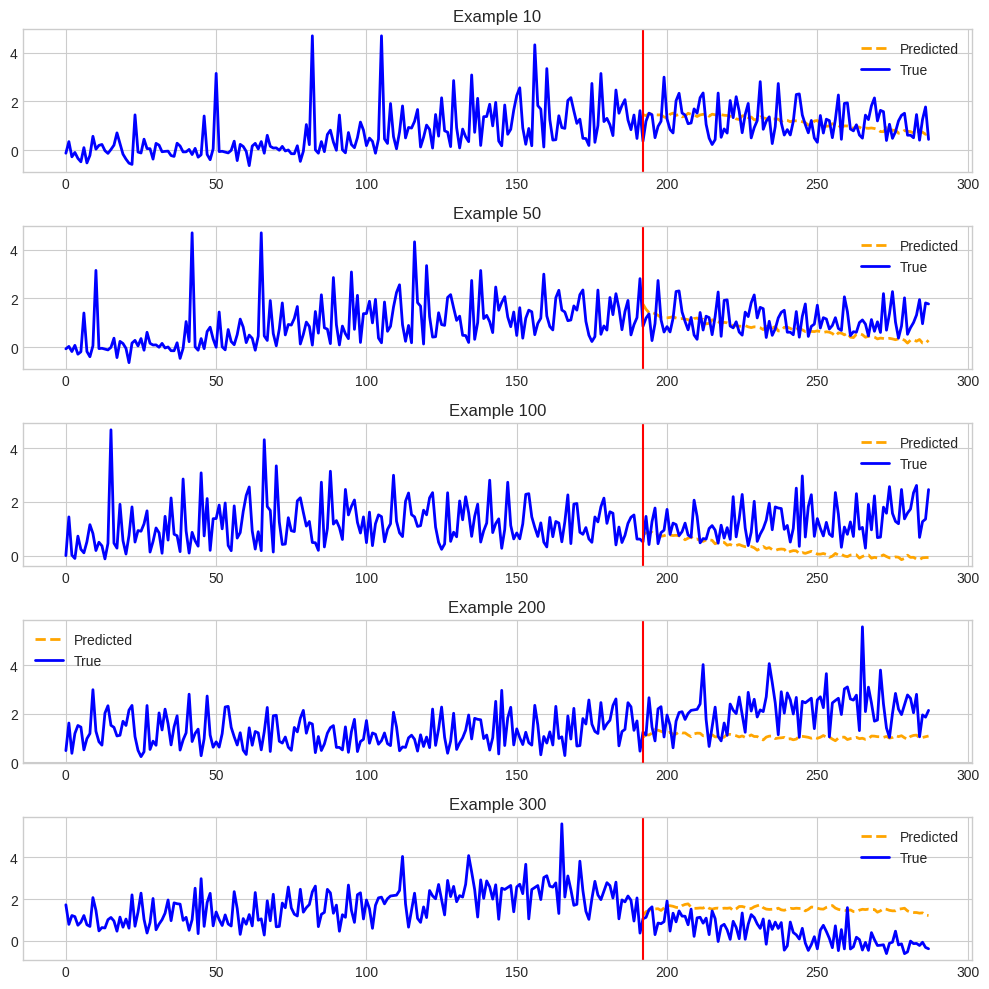

In [ ]:
import os
import tempfile
import pandas as pd
from transformers import Trainer, TrainingArguments, set_seed
from tsfm_public import TimeSeriesPreprocessor, get_datasets
from tsfm_public.toolkit.get_model import get_model
from tsfm_public.toolkit.visualization import plot_predictions

# === Configuration ===
SEED = 42
set_seed(SEED)

TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r2"
CONTEXT_LENGTH = 512
PREDICTION_LENGTH = 96
OUT_DIR = "ttm_pm25_zeroshot"

# === Load your data ===
data = pd.read_csv('merged_exact_on_lat_long.csv', parse_dates=["Timestamp"])

# Sort data chronologically
data = data.sort_values("Timestamp").reset_index(drop=True)

# Define column mappings
column_specifiers = {
    "timestamp_column": "Timestamp",
    "id_columns": [],  # Assuming single time series
    "target_columns": ["PM2.5"],
    "control_columns": [],  # You can add ["Latitude", "Longitude"] if needed
}

# Define splits (e.g., 60% train, 20% val, 20% test)
total_len = len(data)
split_config = {
    "train": [0, int(0.6 * total_len)],
    "valid": [int(0.6 * total_len), int(0.8 * total_len)],
    "test": [int(0.8 * total_len), total_len],
}

# === Preprocess the data ===
tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=CONTEXT_LENGTH,
    prediction_length=PREDICTION_LENGTH,
    scaling=True,
    encode_categorical=False,
    scaler_type="standard",
)

# Load pre-trained TTM model
zeroshot_model = get_model(
    TTM_MODEL_PATH,
    context_length=CONTEXT_LENGTH,
    prediction_length=PREDICTION_LENGTH,
    freq_prefix_tuning=False,
    prefer_l1_loss=False,
    prefer_longer_context=True,
)

# Create dataset splits
dset_train, dset_valid, dset_test = get_datasets(
    tsp, data, split_config,
    use_frequency_token=zeroshot_model.config.resolution_prefix_tuning
)

# Setup Trainer for evaluation
temp_dir = tempfile.mkdtemp()
zeroshot_trainer = Trainer(
    model=zeroshot_model,
    args=TrainingArguments(
        output_dir=temp_dir,
        per_device_eval_batch_size=64,
        seed=SEED,
        report_to="none",
    ),
)

# === Evaluate ===
print("+" * 20, "Zero-Shot Evaluation on PM2.5", "+" * 20)
results = zeroshot_trainer.evaluate(dset_test)
print(results)

# === Predict ===
predictions = zeroshot_trainer.predict(dset_test)
y_pred = predictions.predictions[0]
print("Prediction shape:", y_pred.shape)

# === Visualize Predictions ===
plot_predictions(
    model=zeroshot_trainer.model,
    dset=dset_test,
    plot_dir=OUT_DIR,
    plot_prefix="pm25_test_zeroshot",
    indices=[10, 50, 100, 200, 300],  # You can change these
    channel=0,
)

INFO:p-2777510:t-140051748943680:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2
INFO:p-2777510:t-140051748943680:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-2777510:t-140051748943680:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96


++++++++++++++++++++ Zero-Shot Evaluation on PM2.5 ++++++++++++++++++++


/home/meenakshi.p1798/.conda/envs/ttm-env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 1.6893573999404907, 'eval_runtime': 6.7679, 'eval_samples_per_second': 235.818, 'eval_steps_per_second': 1.921}
Prediction shape: (1596, 96, 1)


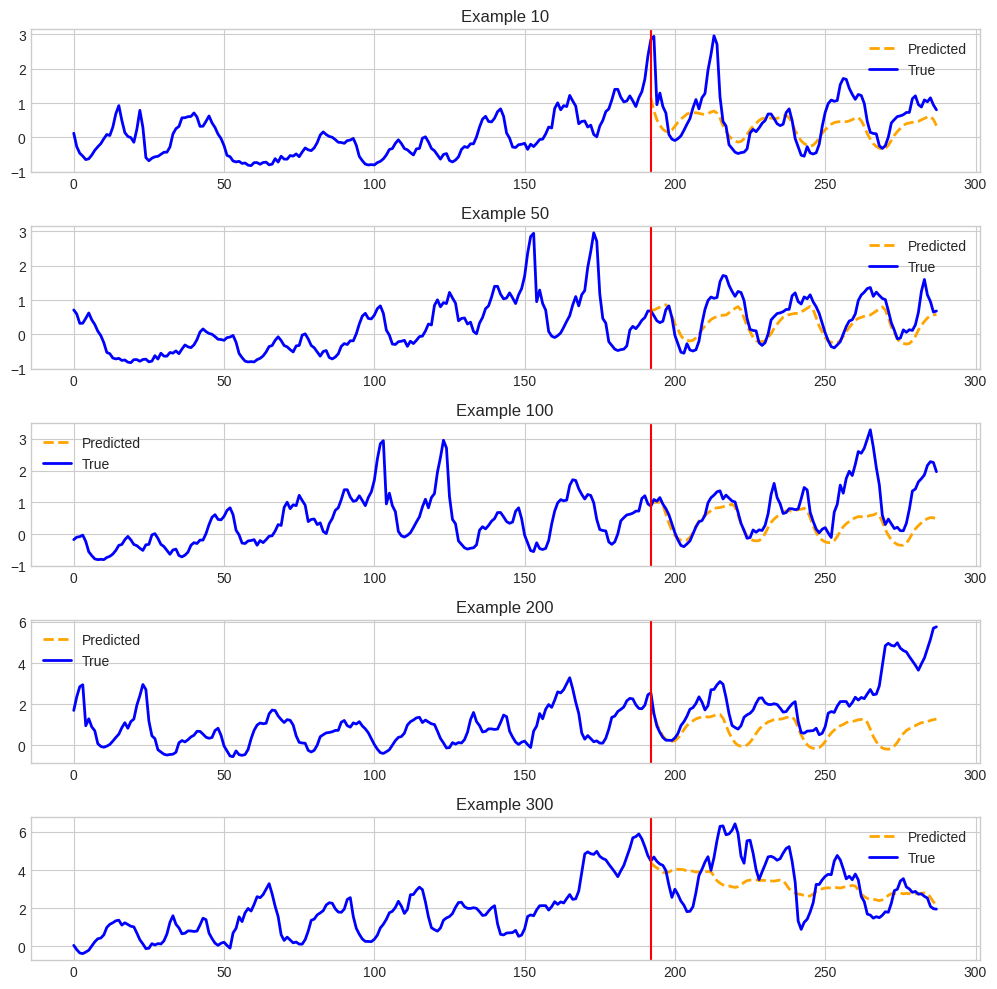

In [ ]:
import os
import tempfile
import pandas as pd
from transformers import Trainer, TrainingArguments, set_seed
from tsfm_public import TimeSeriesPreprocessor, get_datasets
from tsfm_public.toolkit.get_model import get_model
from tsfm_public.toolkit.visualization import plot_predictions

# === Configuration ===
SEED = 42
set_seed(SEED)

TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r2"
CONTEXT_LENGTH = 512
PREDICTION_LENGTH = 96
OUT_DIR = "ttm_pm25_zeroshot"

# === Load your data ===
#data = pd.read_csv('merged_exact_on_lat_long.csv', parse_dates=["Timestamp"])

# Sort data chronologically
data = station_df.sort_values("Timestamp").reset_index(drop=True)

# Define column mappings
column_specifiers = {
    "timestamp_column": "Timestamp",
    "id_columns": [],  # Assuming single time series
    "target_columns": ["PM2.5"],
    "control_columns": [],  # You can add ["Latitude", "Longitude"] if needed
}

# Define splits (e.g., 60% train, 20% val, 20% test)
total_len = len(data)
split_config = {
    "train": [0, int(0.6 * total_len)],
    "valid": [int(0.6 * total_len), int(0.8 * total_len)],
    "test": [int(0.8 * total_len), total_len],
}

# === Preprocess the data ===
tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=CONTEXT_LENGTH,
    prediction_length=PREDICTION_LENGTH,
    scaling=True,
    encode_categorical=False,
    scaler_type="standard",
)

# Load pre-trained TTM model
zeroshot_model = get_model(
    TTM_MODEL_PATH,
    context_length=CONTEXT_LENGTH,
    prediction_length=PREDICTION_LENGTH,
    freq_prefix_tuning=False,
    prefer_l1_loss=False,
    prefer_longer_context=True,
)

# Create dataset splits
dset_train, dset_valid, dset_test = get_datasets(
    tsp, data, split_config,
    use_frequency_token=zeroshot_model.config.resolution_prefix_tuning
)

# Setup Trainer for evaluation
temp_dir = tempfile.mkdtemp()
zeroshot_trainer = Trainer(
    model=zeroshot_model,
    args=TrainingArguments(
        output_dir=temp_dir,
        per_device_eval_batch_size=64,
        seed=SEED,
        report_to="none",
    ),
)

# === Evaluate ===
print("+" * 20, "Zero-Shot Evaluation on PM2.5", "+" * 20)
results = zeroshot_trainer.evaluate(dset_test)
print(results)

# === Predict ===
predictions = zeroshot_trainer.predict(dset_test)
y_pred = predictions.predictions[0]
print("Prediction shape:", y_pred.shape)

# === Visualize Predictions ===
plot_predictions(
    model=zeroshot_trainer.model,
    dset=dset_test,
    plot_dir=OUT_DIR,
    plot_prefix="pm25_test_zeroshot",
    indices=[10, 50, 100, 200, 300],  # You can change these
    channel=0,
)

In [ ]:
import os
import tempfile
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, r2_score
from transformers import Trainer, TrainingArguments, set_seed
from tsfm_public import TimeSeriesPreprocessor, get_datasets
from tsfm_public.toolkit.get_model import get_model

# === Configuration ===
SEED = 42
set_seed(SEED)

TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r2"
CONTEXT_LENGTH = 512
PREDICTION_LENGTH = 96
OUT_DIR = "ttm_pm25_zeroshot"

# === Load your station data ===
# Assuming station_df is already defined for a single station
data = station_df.sort_values("Timestamp").reset_index(drop=True)
# === Manually store mean and std of original PM2.5 for unnormalization ===
pm25_mean = data["PM2.5"].mean()
pm25_std = data["PM2.5"].std()

# === Define column mappings ===
column_specifiers = {
    "timestamp_column": "Timestamp",
    "id_columns": [],
    "target_columns": ["PM2.5"],
    "control_columns": [],
}

# === Define train/val/test splits ===
total_len = len(data)
split_config = {
    "train": [0, int(0.6 * total_len)],
    "valid": [int(0.6 * total_len), int(0.8 * total_len)],
    "test": [int(0.8 * total_len), total_len],
}

# === Preprocess the data ===
tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=CONTEXT_LENGTH,
    prediction_length=PREDICTION_LENGTH,
    scaling=True,
    encode_categorical=False,
    scaler_type="standard",
)

# === Load pre-trained TTM model ===
zeroshot_model = get_model(
    TTM_MODEL_PATH,
    context_length=CONTEXT_LENGTH,
    prediction_length=PREDICTION_LENGTH,
    freq_prefix_tuning=False,
    prefer_l1_loss=False,
    prefer_longer_context=True,
)

# === Create dataset splits ===
dset_train, dset_valid, dset_test = get_datasets(
    tsp, data, split_config,
    use_frequency_token=zeroshot_model.config.resolution_prefix_tuning
)

# === Setup Trainer ===
temp_dir = tempfile.mkdtemp()
zeroshot_trainer = Trainer(
    model=zeroshot_model,
    args=TrainingArguments(
        output_dir=temp_dir,
        per_device_eval_batch_size=64,
        seed=SEED,
        report_to="none",
    ),
)

# === Evaluate ===
print("+" * 20, "Zero-Shot Evaluation on PM2.5", "+" * 20)
results = zeroshot_trainer.evaluate(dset_test)
print("Transformers Evaluate Results:", results)


import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Get predictions
predictions = zeroshot_trainer.predict(dset_test)
y_pred = predictions.predictions[0]  # shape: (num_samples, prediction_length, 1)

# === Get true values manually from dset_test ===
y_true_list = []
for item in dset_test:
    y_true_list.append(item["future_values"].numpy())  # (prediction_length, 1)

y_true = np.stack(y_true_list, axis=0)  # (num_samples, prediction_length, 1)

# === Flatten both arrays ===
y_pred_flat = y_pred.flatten()
y_true_flat = y_true.flatten()

# === Unnormalize ===
y_pred_flat = y_pred.flatten()
y_true_flat = y_true.flatten()


# If accidentally overwritten, recalculate from the raw DataFrame:
pm25_mean = data["PM2.5"].mean()
pm25_std = data["PM2.5"].std()


# Avoid division by zero
if pm25_std == 0:
    pm25_std = 1e-8


y_pred_unnorm = y_pred_flat * pm25_std + pm25_mean
y_true_unnorm = y_true_flat * pm25_std + pm25_mean

# === Remove NaNs ===
mask = ~np.isnan(y_pred_unnorm) & ~np.isnan(y_true_unnorm)
y_pred_clean = y_pred_unnorm[mask]
y_true_clean = y_true_unnorm[mask]

# === Metrics ===
mae = mean_absolute_error(y_true_clean, y_pred_clean)
rmse = np.sqrt(np.mean((y_true_clean - y_pred_clean) ** 2))
r2 = r2_score(y_true_clean, y_pred_clean)

print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

print(f"Unnormalized MAE:  {mae:.4f}")
print(f"Unnormalized RMSE: {rmse:.4f}")
print(f"Unnormalized R²:   {r2:.4f}")

INFO:p-2785559:t-127204942194496:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2
INFO:p-2785559:t-127204942194496:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-2785559:t-127204942194496:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96


++++++++++++++++++++ Zero-Shot Evaluation on PM2.5 ++++++++++++++++++++


/home/meenakshi.p1798/.conda/envs/ttm-env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Transformers Evaluate Results: {'eval_loss': 1.6893573999404907, 'eval_runtime': 7.5306, 'eval_samples_per_second': 211.937, 'eval_steps_per_second': 1.726}
MAE:  138.5698
RMSE: 184.7550
R²:   -1.0523
Unnormalized MAE:  138.5698
Unnormalized RMSE: 184.7550
Unnormalized R²:   -1.0523


In [ ]:
import os
import tempfile
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from transformers import Trainer, TrainingArguments, set_seed
from tsfm_public import TimeSeriesPreprocessor, get_datasets
from tsfm_public.toolkit.get_model import get_model

# === Configuration ===
SEED = 42
set_seed(SEED)

TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r2"
CONTEXT_LENGTH = 512
PREDICTION_LENGTH = 96
OUT_DIR = "ttm_pm25_zeroshot"

# === Data: Your full dataset with all stations ===
# Assuming you already have a DataFrame like `full_data` with "Latitude", "Longitude", "Timestamp", and "PM2.5"

all_metrics = []

# === Loop over each station ===
for station_id, station_df in df.groupby(["latitude", "longitude"]):

    print(f"\n{'='*10} Station: {station_id} {'='*10}")
    
    # Sort time
    station_df['Timestamp']= pd.to_datetime(station_df['Timestamp'])

    data = station_df.sort_values("Timestamp").reset_index(drop=True)

    # Skip if too short
    if len(data) < CONTEXT_LENGTH + PREDICTION_LENGTH:
        print("Skipping due to insufficient length.")
        continue

    # Store mean and std for unnormalization
    pm25_mean = data["PM2.5"].mean()
    pm25_std = data["PM2.5"].std()
    if pm25_std == 0:
        pm25_std = 1e-8

    # Define column specifiers
    column_specifiers = {
        "timestamp_column": "Timestamp",
        "id_columns": [],
        "target_columns": ["PM2.5"],
        "control_columns": [],
    }

    # Split config (e.g., 60-20-20)
    total_len = len(data)
    split_config = {
        "train": [0, int(0.6 * total_len)],
        "valid": [int(0.6 * total_len), int(0.8 * total_len)],
        "test": [int(0.8 * total_len), total_len],
    }

    # Preprocess
    tsp = TimeSeriesPreprocessor(
        **column_specifiers,
        context_length=CONTEXT_LENGTH,
        prediction_length=PREDICTION_LENGTH,
        scaling=True,
        encode_categorical=False,
        scaler_type="standard",
    )

    # Load model
    zeroshot_model = get_model(
        TTM_MODEL_PATH,
        context_length=CONTEXT_LENGTH,
        prediction_length=PREDICTION_LENGTH,
        freq_prefix_tuning=False,
        prefer_l1_loss=False,
        prefer_longer_context=True,
    )

    # Prepare datasets
    try:
        dset_train, dset_valid, dset_test = get_datasets(
            tsp, data, split_config,
            use_frequency_token=zeroshot_model.config.resolution_prefix_tuning
        )
    except Exception as e:
        print(f"Skipping station due to dataset creation error: {e}")
        continue

    # Trainer
    temp_dir = tempfile.mkdtemp()
    zeroshot_trainer = Trainer(
        model=zeroshot_model,
        args=TrainingArguments(
            output_dir=temp_dir,
            per_device_eval_batch_size=64,
            seed=SEED,
            report_to="none",
        ),
    )

    # Predict
    predictions = zeroshot_trainer.predict(dset_test)
    y_pred = predictions.predictions[0]

    # Ground truth
    y_true_list = [item["future_values"].numpy() for item in dset_test]
    y_true = np.stack(y_true_list, axis=0)

    # Flatten
    y_pred_flat = y_pred.flatten()
    y_true_flat = y_true.flatten()

    # Unnormalize
    y_pred_unnorm = y_pred_flat * pm25_std + pm25_mean
    y_true_unnorm = y_true_flat * pm25_std + pm25_mean

    # Clean NaNs
    mask = ~np.isnan(y_pred_unnorm) & ~np.isnan(y_true_unnorm)
    y_pred_clean = y_pred_unnorm[mask]
    y_true_clean = y_true_unnorm[mask]

    # Metrics
    mae = mean_absolute_error(y_true_clean, y_pred_clean)
    rmse = np.sqrt(mean_squared_error(y_true_clean, y_pred_clean))
    r2 = r2_score(y_true_clean, y_pred_clean)

    print(f"MAE:  {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

    all_metrics.append({
        "Latitude": station_id[0],
        "Longitude": station_id[1],
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
    })

# === Final summary ===
results_df = pd.DataFrame(all_metrics)
print("\n========== Summary ==========")
print(results_df)

# Optional: Save to CSV
results_df.to_csv("ttm_zero_shot_results.csv", index=False)

INFO:p-2785559:t-127204942194496:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2



========== Station: (28.498571, 77.26484) ==========


INFO:p-2785559:t-127204942194496:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-2785559:t-127204942194496:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96
/home/meenakshi.p1798/.conda/envs/ttm-env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


INFO:p-2785559:t-127204942194496:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


MAE:  125.3828, RMSE: 165.8418, R²: -0.6536

========== Station: (28.530785, 77.271255) ==========


INFO:p-2785559:t-127204942194496:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-2785559:t-127204942194496:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96
/home/meenakshi.p1798/.conda/envs/ttm-env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


INFO:p-2785559:t-127204942194496:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


MAE:  144.8189, RMSE: 252.8505, R²: -2.2283

========== Station: (28.531346, 77.190156) ==========


INFO:p-2785559:t-127204942194496:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-2785559:t-127204942194496:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96
/home/meenakshi.p1798/.conda/envs/ttm-env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


INFO:p-2785559:t-127204942194496:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


MAE:  114.2118, RMSE: 155.4974, R²: -0.9421

========== Station: (28.563262, 77.186937) ==========


INFO:p-2785559:t-127204942194496:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-2785559:t-127204942194496:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96
/home/meenakshi.p1798/.conda/envs/ttm-env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


INFO:p-2785559:t-127204942194496:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


MAE:  136.5411, RMSE: 182.9021, R²: -0.8625

========== Station: (28.56789, 77.250515) ==========


INFO:p-2785559:t-127204942194496:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-2785559:t-127204942194496:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96
/home/meenakshi.p1798/.conda/envs/ttm-env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


INFO:p-2785559:t-127204942194496:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


MAE:  158.4392, RMSE: 202.1025, R²: -1.6434

========== Station: (28.570173, 76.933762) ==========


INFO:p-2785559:t-127204942194496:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-2785559:t-127204942194496:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96
/home/meenakshi.p1798/.conda/envs/ttm-env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


INFO:p-2785559:t-127204942194496:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


MAE:  136.4439, RMSE: 185.0613, R²: -0.9098

========== Station: (28.571027, 77.071901) ==========


INFO:p-2785559:t-127204942194496:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-2785559:t-127204942194496:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96
/home/meenakshi.p1798/.conda/envs/ttm-env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


INFO:p-2785559:t-127204942194496:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


MAE:  120.6212, RMSE: 161.1326, R²: -0.7100

========== Station: (28.57834, 77.184) ==========


INFO:p-2785559:t-127204942194496:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-2785559:t-127204942194496:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96
/home/meenakshi.p1798/.conda/envs/ttm-env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


INFO:p-2785559:t-127204942194496:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


MAE:  66.5326, RMSE: 89.0952, R²: -0.4125

========== Station: (28.58028, 77.233829) ==========


INFO:p-2785559:t-127204942194496:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-2785559:t-127204942194496:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96
/home/meenakshi.p1798/.conda/envs/ttm-env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


INFO:p-2785559:t-127204942194496:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


MAE:  130.5390, RMSE: 304.8757, R²: -5.8124

========== Station: (28.611281, 77.237738) ==========


INFO:p-2785559:t-127204942194496:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-2785559:t-127204942194496:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96
/home/meenakshi.p1798/.conda/envs/ttm-env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


INFO:p-2785559:t-127204942194496:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


MAE:  127.9260, RMSE: 172.1581, R²: -1.0048

========== Station: (28.623763, 77.287209) ==========


INFO:p-2785559:t-127204942194496:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-2785559:t-127204942194496:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96
/home/meenakshi.p1798/.conda/envs/ttm-env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


INFO:p-2785559:t-127204942194496:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


MAE:  127.0864, RMSE: 166.2108, R²: -0.9703

========== Station: (28.636429, 77.201067) ==========


INFO:p-2785559:t-127204942194496:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-2785559:t-127204942194496:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96
/home/meenakshi.p1798/.conda/envs/ttm-env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


INFO:p-2785559:t-127204942194496:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


MAE:  127.1872, RMSE: 167.0650, R²: -0.8854

========== Station: (28.639652, 77.146275) ==========


INFO:p-2785559:t-127204942194496:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-2785559:t-127204942194496:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96
/home/meenakshi.p1798/.conda/envs/ttm-env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


INFO:p-2785559:t-127204942194496:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


MAE:  116.2018, RMSE: 163.8270, R²: -0.8397

========== Station: (28.647622, 77.315809) ==========


INFO:p-2785559:t-127204942194496:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-2785559:t-127204942194496:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96
/home/meenakshi.p1798/.conda/envs/ttm-env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


INFO:p-2785559:t-127204942194496:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


MAE:  90.4583, RMSE: 133.7906, R²: -0.1156

========== Station: (28.656756, 77.227234) ==========


INFO:p-2785559:t-127204942194496:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-2785559:t-127204942194496:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96
/home/meenakshi.p1798/.conda/envs/ttm-env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


INFO:p-2785559:t-127204942194496:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


MAE:  23.9500, RMSE: 38.5169, R²: -2.4726

========== Station: (28.672342, 77.31526) ==========


INFO:p-2785559:t-127204942194496:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-2785559:t-127204942194496:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96
/home/meenakshi.p1798/.conda/envs/ttm-env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


INFO:p-2785559:t-127204942194496:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


MAE:  128.5216, RMSE: 213.7483, R²: -1.8492

========== Station: (28.674045, 77.131023) ==========


INFO:p-2785559:t-127204942194496:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-2785559:t-127204942194496:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96
/home/meenakshi.p1798/.conda/envs/ttm-env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


INFO:p-2785559:t-127204942194496:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


MAE:  173.3079, RMSE: 226.3966, R²: -0.6742

========== Station: (28.684678, 77.076574) ==========


INFO:p-2785559:t-127204942194496:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-2785559:t-127204942194496:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96
/home/meenakshi.p1798/.conda/envs/ttm-env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


INFO:p-2785559:t-127204942194496:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


MAE:  179.6162, RMSE: 237.1200, R²: -1.0455

========== Station: (28.695381, 77.181665) ==========


INFO:p-2785559:t-127204942194496:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-2785559:t-127204942194496:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96
/home/meenakshi.p1798/.conda/envs/ttm-env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


INFO:p-2785559:t-127204942194496:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


MAE:  153.2667, RMSE: 200.1573, R²: -1.1606

========== Station: (28.699793, 77.165453) ==========


INFO:p-2785559:t-127204942194496:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-2785559:t-127204942194496:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96
/home/meenakshi.p1798/.conda/envs/ttm-env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


INFO:p-2785559:t-127204942194496:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


MAE:  176.0839, RMSE: 238.5066, R²: -0.8369

========== Station: (28.710508, 77.249485) ==========


INFO:p-2785559:t-127204942194496:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-2785559:t-127204942194496:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96
/home/meenakshi.p1798/.conda/envs/ttm-env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


INFO:p-2785559:t-127204942194496:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


MAE:  156.1085, RMSE: 210.5246, R²: -1.0356

========== Station: (28.732528, 77.11992) ==========


INFO:p-2785559:t-127204942194496:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-2785559:t-127204942194496:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96
/home/meenakshi.p1798/.conda/envs/ttm-env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


INFO:p-2785559:t-127204942194496:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


MAE:  161.8809, RMSE: 248.6511, R²: -1.5806

========== Station: (28.73282, 77.170633) ==========


INFO:p-2785559:t-127204942194496:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-2785559:t-127204942194496:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96
/home/meenakshi.p1798/.conda/envs/ttm-env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


INFO:p-2785559:t-127204942194496:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


MAE:  176.3313, RMSE: 247.8692, R²: -1.3629

========== Station: (28.7762, 77.051074) ==========


INFO:p-2785559:t-127204942194496:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-2785559:t-127204942194496:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96
/home/meenakshi.p1798/.conda/envs/ttm-env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


INFO:p-2785559:t-127204942194496:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


MAE:  166.1723, RMSE: 215.5069, R²: -0.9087

========== Station: (28.822836, 77.101981) ==========


INFO:p-2785559:t-127204942194496:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-2785559:t-127204942194496:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96
/home/meenakshi.p1798/.conda/envs/ttm-env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


MAE:  121.0033, RMSE: 160.3336, R²: -0.6041

========== Summary ==========
     Latitude  Longitude         MAE        RMSE        R2
0   28.498571  77.264840  125.382805  165.841798 -0.653606
1   28.530785  77.271255  144.818893  252.850453 -2.228309
2   28.531346  77.190156  114.211800  155.497431 -0.942070
3   28.563262  77.186937  136.541138  182.902093 -0.862456
4   28.567890  77.250515  158.439240  202.102494 -1.643363
5   28.570173  76.933762  136.443893  185.061307 -0.909759
6   28.571027  77.071901  120.621201  161.132649 -0.710029
7   28.578340  77.184000   66.532562   89.095219 -0.412505
8   28.580280  77.233829  130.538986  304.875679 -5.812429
9   28.611281  77.237738  127.926033  172.158074 -1.004760
10  28.623763  77.287209  127.086357  166.210839 -0.970335
11  28.636429  77.201067  127.187233  167.065008 -0.885372
12  28.639652  77.146275  116.201843  163.826968 -0.839672
13  28.647622  77.315809   90.458267  133.790560 -0.115589
14  28.656756  77.227234   23.949972   3